---

### **Implementation of a matrix completion problem**


Ikram EL KHANBAA
\
Yousra Lina EL KHALLOUFI


---


After reading and understanding '*Implicit Regularization in Matrix Factorization (2017)*' by Gunasekar et al., we decided to implement a matrix completion problem in order to empirically understand the results presented by the paper.

# **Data**

We will use the MovieLens dataset (the same used in the paper). We will construct our matrix based on this dataset.

We upload our MovieLens dataset from https://grouplens.org/datasets/movielens/. We use the smallest dataset with 100 000 ratings, this dataset is aimed for educational use.

In [7]:
#first imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Our main goal is not to perform predictions on the ratings, or to carry out a recommandation system. We mainly aim to predict some entries of a matrix using gradient descent on the factorization of the matrix and to see if the output of the gradient is close to the minimum of the nuclear norm as suggested by the conjecture of the paper.

Hence, our focus will be only on numerical data and more particularly on the ratings of the movies.

In [8]:
#reading the data

df = pd.read_csv('ratings.csv')

In [9]:
df.shape

(100836, 4)

In [10]:
df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The dataset presents 100836 observations, each observation corresponds to a rating of a user on a movie.

(array([ 4181.,  9342., 25597., 39954., 21762.]),
 array([0.5, 1.4, 2.3, 3.2, 4.1, 5. ]),
 <BarContainer object of 5 artists>)

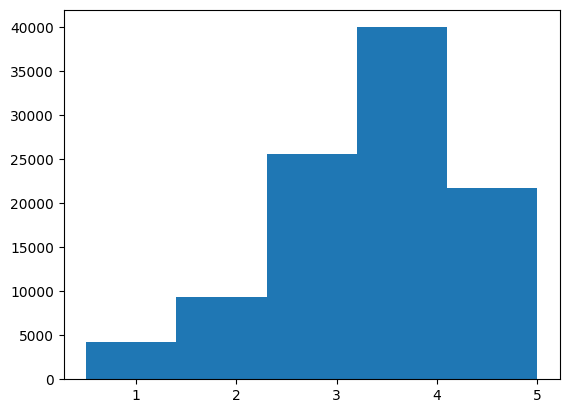

In [11]:
#Histogram of the ratings

plt.hist(df['rating'], bins = 5)

In this first visualization, we see that the most common rating is 4

In [12]:
#Description of the dataset

df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


The average rating is 3.5

In [13]:
#missing values

df.isnull(). any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

The dataset does not present any missing values.

In [14]:
#types of data

df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Our variable of interest, the ratings, is a float which is wanted.

**Our matrix**

After the first exploration of the data, we are now interested in constructing our matrix $X$.

In order to obtain a matrix in $R^{n \times m}$, with the entries being the ratings, we pivot our dataset. The rows of the matrix corresponds to the users and the columns to the movies. Hence, we have a matrix full of ratings but with lots of zeros as not every movie is rated by every user.

In [15]:
mtrx_df = df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
mtrx_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We convert our pandas dataframe to a numpy array to insure its goodfit with numpy methods.

In [16]:
X = mtrx_df.to_numpy()

The paper mainly studies the case of $X \in R^{n \times n}$, and gives a short overview of the case of $X \in R^{n \times m}$. Hence, to be in phase with the paper we reshape our matrix to be of size $n \times n$

In [17]:
X = X[:, :X.shape[0]]

We normalize our data, since its full of zeros it could introduce bias into our results.

In [18]:
X = (X - np.mean(X)) / np.std(X)

Now, we hide $m$ entries of $X$. Here we take $m=100$ as we should have $m << n \times n$ and we stock the positions of the hidden entries.

In [19]:
#We hide m values from X

m = 100
n = X.shape[1]

row_positions = np.random.choice(np.arange(n), size=m, replace=True)
col_positions = np.random.choice(np.arange(n), size=m, replace=True)

# List of zero positions as tuples
ones_positions_list = list(zip(row_positions, col_positions))


Our problem is the following:

$\min _{X \succeq 0} F(X)=\|\mathcal{A}(X)-y\|_2^2$




We need to define our linear operator $\mathcal{A}$ such that $\mathcal{A}(X)_i = \langle A_i, X_i \rangle, A_i \in \mathbb{R}^{n \times n}$. To do so we have to define the matrices of indicators $A_{i}$. For $i$, $A_{i}$ is full of zeros but at the $i^{th}$ position it has a one. It indicates the position of the $i^{th}$ we hid.

In [20]:
def A(k):
  A_k = np.zeros((n,n))
  i,j = ones_positions_list[k]
  A_k[i,j] = 1
  return A_k

Now that $A_i$ are defined, we can define our linear operator $\mathcal{A}$. We consider that the scalar product between two matrices is the trace of the matricial product of the transpose of one matrix times the other matrix.

In [21]:
def linear_operator_A(X):
    result = np.zeros((m,1))
    for i in range(m):
      A_i = A(i)
      result[i,0] = np.trace(np.dot(A(i).T,X))
    return result

The last component we need is $y$, it is the vector that conserves all the hidden entries.

In [22]:
y = list(X[i, j] for i, j in ones_positions_list)

In [23]:
y = np.array(y)

In [24]:
y = y.reshape((m,1))

# **Completion of X**

**Gradient descent**

Now that everything is ready, we can proceed to compute the gradient descent.

The gradient descent won't be done on $X$ but instead on $U$ with $X = U^{T}.U$

We initialize our $U$ but with small values as suggested by the paper.

In [25]:
#Initialize U

U = np.random.rand(n, n) * 0.01 #U with small values


We define our parameters:

In [26]:
#parameters

learning_rate = 0.01
num_iterations = 50

We go for a small number of iterations as the operations are highly computational (with 1000 iterations the algorithm run for 24h before breaking out)

We define our objective function :            
\
$\|\mathcal{A}(U^{T}.U)-y\|_2^2$

In [27]:
def objective_function(U, A, y):
    X = np.dot(U, U.T)
    return np.linalg.norm(linear_operator_A(X) - y) ** 2 / 2

At the iteration $t$, the formula of the gradient respectfully to $U_{t}$ is :         
$\dot{U}_t = -\mathcal{A^*} (\mathcal{A}(U_t U_t^*) - y)U_t$
\
\
We need to define $\mathcal{A^*}$, the adjoint of $\mathcal{A}$:

In [28]:
def A_adjoint(y,n):
  A_adj= np.zeros((n,n))
  for i in range(y.shape[0]):
    A_adj += y[i,0] * A(i)
  return A_adj

Now we can implement our gradient:

In [29]:
def gradient(U, A, y):
    X = np.dot(U, U.T)
    grad_U = - np.dot(A_adjoint(linear_operator_A(X) - y ,n),U)
    return grad_U

In [30]:
for i in range(num_iterations):
    grad_U = gradient(U, A, y)
    U -= learning_rate * grad_U

    #Project U to ensure it remains positive semidefinite
    U = np.maximum(U, 0)

In [31]:
U

array([[0.00976019, 0.00786648, 0.00806285, ..., 0.00148944, 0.00487209,
        0.00783945],
       [0.0103051 , 0.00468349, 0.00945615, ..., 0.00591567, 0.00719875,
        0.00182567],
       [0.00678142, 0.00368207, 0.00567286, ..., 0.00898115, 0.00772865,
        0.00464787],
       ...,
       [0.00098445, 0.00313223, 0.0052191 , ..., 0.00650485, 0.00908888,
        0.00092381],
       [0.00689737, 0.00833672, 0.00240279, ..., 0.00711599, 0.00101121,
        0.00058821],
       [0.00587445, 0.00985445, 0.00296151, ..., 0.00463627, 0.00807963,
        0.00795636]])

The first reflex is to compare $X$ to $U.U^{T}$ as they are supposed to be equal

In [32]:
np.linalg.norm(X-np.dot(U,U.T))

610.1447355360805

Is the difference big ? We cannot conclude.

**The minimum of the nuclear norm**

The paper postulates that the gradient flow converges to the minimum of the nuclear norm under the constraint that $\mathcal{A}(X)= y$.
\
In aim to test this result on our gradient descent we need to solve the minimization problem of the nuclear norm.

Firstly, we define the nuclear norm

In [33]:
#nuclear norm

def nuclear_norm(matrix):
    x_matrix = matrix.reshape((n,n))
    singular_values = np.linalg.svd(x_matrix, compute_uv=False)
    nuclear_norm_value = np.sum(singular_values)
    return nuclear_norm_value



We use the package cvxpy that provides solvers suitable for variables in $R^{n \times \n}$

In [34]:
import cvxpy as cp

X_param = cp.Parameter((n, n))
y_param = cp.Parameter((m, 1))
A_X = cp.Parameter((m, 1))

X_param.value = X
y_param.value = y
A_X.value = linear_operator_A(X)

constraint = [A_X == y_param]

objective = cp.Minimize(cp.norm(X_param, "nuc")) #the package already understands the nuclear norm

problem = cp.Problem(objective, constraint)

problem.solve()

result_matrix = X_param.value

# Print the result
print("Optimal Matrix:")
print(result_matrix)


Optimal Matrix:
[[ 4.76969727 -0.22010057  4.76969727 ... -0.22010057 -0.22010057
  -0.22010057]
 [-0.22010057 -0.22010057 -0.22010057 ... -0.22010057 -0.22010057
  -0.22010057]
 [-0.22010057 -0.22010057 -0.22010057 ... -0.22010057 -0.22010057
  -0.22010057]
 ...
 [ 2.89852308  2.27479835  2.27479835 ...  2.27479835 -0.22010057
  -0.22010057]
 [ 3.52224781 -0.22010057 -0.22010057 ... -0.22010057 -0.22010057
  -0.22010057]
 [ 6.01714673 -0.22010057 -0.22010057 ... -0.22010057 -0.22010057
  -0.22010057]]


In [35]:
# from scipy.optimize import minimize
# initial_guess = np.ones((n,n)).flatten()

# # Define the constraint as a dictionary
# constraint = {'type': 'eq', 'fun': constraint_function}

# # Setup the optimization problem
# optimization_result = minimize(nuclear_norm, initial_guess, constraints=constraint, method = "SLSQP")

# # Extract the result
# optimized_X = optimization_result.X

# # Print the result
# print("Optimized X:", optimized_X)
# print("Minimum norm:", optimization_result.fun)
# print("Constraint value:", constraint(optimized_X))

Now we compare our result matrix to the gradient flow to see if they are close.

In [36]:
np.linalg.norm(result_matrix - U)

610.0246414421141

Computing this difference is not enough to conclude because :



1.   The number of iterations is low, can we talk about convergence in this context?
2.   We need to perform more than one computation of the gradient and take the average. This is more convenient if we want to interpret the results respectfully to the paper.



**An alternative of computing the gradient : torch framework**

In [ ]:
import torch
import numpy as np

def A(k):
    A_k = torch.zeros((n, n))
    i, j = ones_positions_list[k]
    A_k[i, j] = 1
    return A_k

y = torch.tensor([X[i, j] for i, j in ones_positions_list], dtype=torch.float32).view(-1, 1)

U = torch.nn.Parameter(torch.rand((n, n), requires_grad=True) * 0.01)

learning_rate = 0.01
num_iterations = 50

def linear_operator_A(X):
    result = torch.zeros((m, 1))
    for i in range(m):
        A_i = A(i)
        result[i, 0] = torch.trace(torch.matmul(A(i).t(), X))
    return result

def objective_function(U, A, y):
    X = torch.matmul(U, U.t())
    return torch.norm(linear_operator_A(X) - y).pow(2) / 2

def A_adjoint(y, n):
    A_adj = torch.zeros((n, n))
    for i in range(y.shape[0]):
        A_adj += y[i, 0] * A(i)
    return A_adj

def gradient(U, A, y):
    X = torch.matmul(U, U.t())
    grad_U = -torch.matmul(A_adjoint(linear_operator_A(X) - y, n), U)
    return grad_U

optimizer = torch.optim.SGD([U], lr=learning_rate)

for i in range(num_iterations):
    optimizer.zero_grad()
    loss = objective_function(U, A, y)
    loss.backward()
    optimizer.step()
    U.data = torch.maximum(U, torch.zeros_like(U))

# Final U after optimization
final_U = U.detach().numpy()

In [ ]:
final_U